In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
T1_PATH = "Shanghai_Datasets/Shanghai_T1DM_merged.xlsx"
T2_PATH = "Shanghai_Datasets/Shanghai_T2DM_merged.xlsx"
OUTPUT_COMBINED = "Shanghai_Datasets/Shanghai_AllPatients_Merged.xlsx"

# CGM sampling interval in minutes (your data is 15-min)
SAMPLING_MINUTES = 15

# Choose prediction horizon:
# 1 step = 15 min, 2 steps = 30 min, 4 steps = 60 min, etc.
PREDICTION_HORIZON_STEPS = 2   # default: 30 minutes ahead (2 * 15 = 30)
SEQUENCE_LENGTH = 8            # default: 8 steps of history => 2 hours (8 * 15 = 120)

In [7]:
def load_and_combine(t1_path=T1_PATH, t2_path=T2_PATH, out_path=OUTPUT_COMBINED):
    df_t1 = pd.read_excel(t1_path)
    df_t2 = pd.read_excel(t2_path)

    df_t1["Diabetes_Type"] = "T1DM"
    df_t2["Diabetes_Type"] = "T2DM"

    df = pd.concat([df_t1, df_t2], ignore_index=True)
    df.to_excel(out_path, index=False)
    print("Combined shape:", df.shape)
    return df

In [8]:
df = load_and_combine()

Combined shape: (21299, 16)


In [9]:
def clean_glucose_dataset(df):
    # Rename columns to standard names (only those we need)
    df = df.rename(columns={
        'Date': 'time',
        'CGM (mg / dl)': 'glucose',
        'Dietary intake': 'food_intake',
        '进食量': 'food_intake_cn',
        '饮食': 'food_cn',
        'Insulin dose - s.c.': 'insulin_sc',
        'CSII - bolus insulin (Novolin R, IU)': 'bolus',
        'CSII - basal insulin (Novolin R, IU / H)': 'basal',
        'CSII - bolus insulin (Novolin R  IU)': 'bolus_dup',
        'CSII - basal insulin (Novolin R  IU / H)': 'basal_dup',
        'CSII - bolus insulin (Novolin R  IU)': 'bolus_dup',
        'CSII - basal insulin (Novolin R  IU / H)': 'basal_dup'
    })

    # parse datetime
    df['time'] = pd.to_datetime(df['time'], errors='coerce')

    # drop rows with bad timestamps
    df = df.dropna(subset=['time'])

    # unify bolus/basal duplicates if present
    if 'bolus' in df.columns and 'bolus_dup' in df.columns:
        df['bolus'] = df['bolus'].fillna(df['bolus_dup'])
    if 'basal' in df.columns and 'basal_dup' in df.columns:
        df['basal'] = df['basal'].fillna(df['basal_dup'])

    # keep relevant set (you can expand later)
    keep_cols = ['time', 'glucose', 'food_intake', 'food_intake_cn', 'insulin_sc',
                 'bolus', 'basal', 'Patient_ID', 'Diabetes_Type']
    # Keep only those that exist
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols]

    # sort and reset index
    df = df.sort_values('time').reset_index(drop=True)

    return df

In [10]:
df_raw = load_and_combine()
df_clean = clean_glucose_dataset(df_raw)

print(df_clean.head())
print(df_clean.info())

Combined shape: (21299, 16)
                 time  glucose                       food_intake  \
0 2020-11-02 09:40:00    102.6                               NaN   
1 2020-11-02 09:55:00     97.2                               NaN   
2 2020-11-02 10:10:00     95.4                               NaN   
3 2020-11-02 10:25:00     91.8  Boiled egg 40 g \nCucumber 100 g   
4 2020-11-02 10:40:00     86.4                               NaN   

  food_intake_cn           insulin_sc  bolus  basal       Patient_ID  \
0            NaN                  NaN    NaN    NaN  2001_0_20201102   
1            NaN                  NaN    NaN    NaN  2001_0_20201102   
2            NaN  Humulin 70/30  8 IU    NaN    NaN  2001_0_20201102   
3            NaN                  NaN    NaN    NaN  2001_0_20201102   
4            NaN                  NaN    NaN    NaN  2001_0_20201102   

  Diabetes_Type  
0          T2DM  
1          T2DM  
2          T2DM  
3          T2DM  
4          T2DM  
<class 'pandas.core.fr

In [11]:
def feature_engineer(df, sampling_minutes=SAMPLING_MINUTES, horizon_steps=PREDICTION_HORIZON_STEPS):
    # set time index
    df = df.set_index('time').sort_index()

    # create target: glucose shifted -horizon_steps
    df['target_glucose'] = df['glucose'].shift(-horizon_steps)

    # create lags
    lags = [1, 2, 3, 6]  # you can change
    for lag in lags:
        df[f'glucose_lag_{lag}'] = df['glucose'].shift(lag)

    # rolling and trend (window in steps)
    window_1h = int(60 / sampling_minutes)  # number of samples per hour
    if window_1h < 1: window_1h = 1
    df[f'glucose_rolling_mean_{window_1h}'] = df['glucose'].rolling(window_1h).mean()
    df[f'glucose_trend_{window_1h}'] = df['glucose'] - df['glucose'].shift(window_1h)

    # time features
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # define features list (only those present)
    feature_candidates = ['glucose'] + \
        [f'glucose_lag_{lag}' for lag in lags] + \
        [f'glucose_rolling_mean_{window_1h}', f'glucose_trend_{window_1h}', 'hour_sin', 'hour_cos']

    features = [f for f in feature_candidates if f in df.columns]

    # drop rows with NaN in any of features or target
    df_clean = df[features + ['target_glucose']].dropna()

    return df_clean, features

In [14]:
def create_sequences_from_df(df_clean, features, seq_len=SEQUENCE_LENGTH, pred_horizon=PREDICTION_HORIZON_STEPS):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_clean[features])
    scaled_df = pd.DataFrame(scaled, columns=features, index=df_clean.index)
    scaled_df['target_glucose'] = df_clean['target_glucose'].values

    X, y = [], []
    for i in range(seq_len, len(scaled_df) - pred_horizon + 1):
        X.append(scaled_df[features].iloc[i-seq_len:i].values)
        y.append(scaled_df['target_glucose'].iloc[i + pred_horizon - 1])
    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

In [12]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [20]:
def run_full_pipeline(t1_path=T1_PATH, t2_path=T2_PATH,
                      seq_len=SEQUENCE_LENGTH, pred_horizon=PREDICTION_HORIZON_STEPS,
                      epochs=50, batch_size=32):
    
    # load & combine
    df_combined = load_and_combine(t1_path, t2_path, out_path=OUTPUT_COMBINED)

    # clean
    df_cleaned = clean_glucose_dataset(df_combined)
    print("After cleaning:", df_cleaned.shape)

    # feature engineering
    df_features, features = feature_engineer(df_cleaned, sampling_minutes=SAMPLING_MINUTES,
                                             horizon_steps=pred_horizon)
    print("Features available:", features)
    print("After feature engineering:", df_features.shape)

    # create sequences
    X, y, scaler = create_sequences_from_df(df_features, features, seq_len, pred_horizon)
    print("X shape", X.shape, "y shape", y.shape)

    # train/test (time-based split)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # build and train
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
                 ReduceLROnPlateau(patience=6, factor=0.5)]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

    # predictions
    y_pred = model.predict(X_test).flatten()

    # metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.3f}  RMSE: {rmse:.3f}  R2: {r2:.3f}")

    # save model and scaler
    model.save("cgm_lstm_model.h5")
    import joblib
    joblib.dump(scaler, "cgm_scaler.save")

    # return everything needed for evaluation and plotting
    return {
        'model': model,
        'scaler': scaler,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'history': history,
        'features': features
    }


# -----------------------
# Run pipeline and get everything
# -----------------------
if __name__ == "__main__":
    artifacts = run_full_pipeline(epochs=50, batch_size=32)

    # extract variables for plotting/evaluation
    model = artifacts['model']
    scaler = artifacts['scaler']
    X_train = artifacts['X_train']
    X_test = artifacts['X_test']
    y_train = artifacts['y_train']
    y_test = artifacts['y_test']
    y_pred = artifacts['y_pred']
    history = artifacts['history']
    features = artifacts['features']

    # now you can run your evaluation and plotting code as-is


Combined shape: (21299, 16)
After cleaning: (21299, 9)
Features available: ['glucose', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3', 'glucose_lag_6', 'glucose_rolling_mean_4', 'glucose_trend_4', 'hour_sin', 'hour_cos']
After feature engineering: (21291, 10)
X shape (21282, 8, 9) y shape (21282,)


C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 10331.6094 - mae: 78.8895 - val_loss: 1712.2180 - val_mae: 28.4515 - learning_rate: 0.0010
Epoch 2/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1535.8531 - mae: 29.0718 - val_loss: 765.9914 - val_mae: 20.3459 - learning_rate: 0.0010
Epoch 3/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1175.5856 - mae: 25.6479 - val_loss: 656.8257 - val_mae: 17.4682 - learning_rate: 0.0010
Epoch 4/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1053.4077 - mae: 24.0430 - val_loss: 625.9108 - val_mae: 17.1572 - learning_rate: 0.0010
Epoch 5/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 983.7949 - mae: 23.2175 - val_loss: 609.8844 - val_mae: 17.1590 - learning_rate: 0.0010
Epoch 6/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 918.8154 - mae: 22.3421 - val_loss: 603.2889 - val_mae: 16.6364 - learning_rate: 0.0010
Epoch 7/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 849.1931 - mae: 21.4294 - val_loss: 585.7994 -

MAE: 16.042  RMSE: 23.415  R2: 0.785


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 16.042, RMSE: 23.415, R²: 0.785
Within 20% of actual: 85.6%


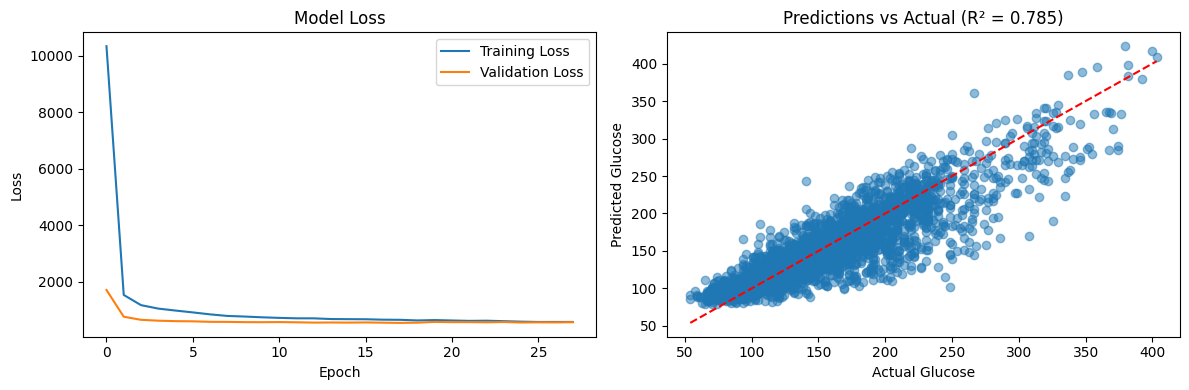

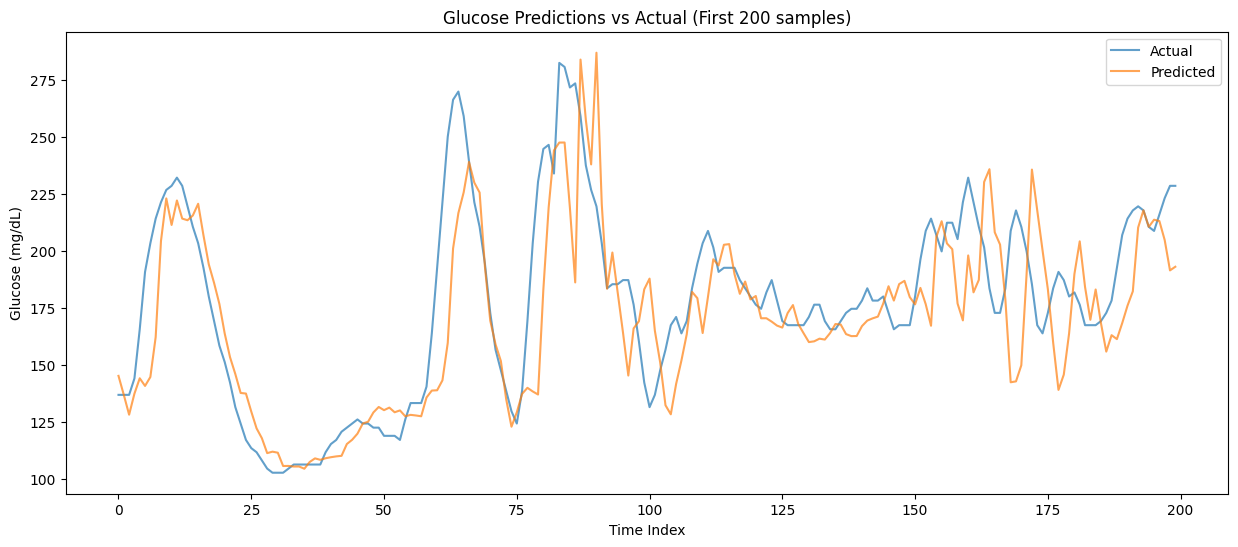

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Next 6 steps predictions: [np.float32(184.46172), np.float32(303.9843), np.float32(322.73096), np.float32(358.90817), np.float32(391.2223), np.float32(420.70743)]


In [21]:
# -----------------------
# 1) Evaluate and Plot after training
# -----------------------
# Assuming you have: model, X_test, y_test, features, history



# Predictions on test set
y_pred = model.predict(X_test).flatten()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Clinical accuracy: % within 20% of actual
within_20_percent = np.mean(np.abs(y_test - y_pred) / y_test < 0.2) * 100
print(f"Within 20% of actual: {within_20_percent:.1f}%")

# -----------------------
# 2) Plot training history & predictions
# -----------------------
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Predictions vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Glucose')
plt.ylabel('Predicted Glucose')
plt.title(f'Predictions vs Actual (R² = {r2:.3f})')

plt.tight_layout()
plt.show()

# Time series plot (first 200 samples)
plt.figure(figsize=(15, 6))
plt.plot(y_test[:200], label='Actual', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.title('Glucose Predictions vs Actual (First 200 samples)')
plt.xlabel('Time Index')
plt.ylabel('Glucose (mg/dL)')
plt.legend()
plt.show()

# -----------------------
# 3) Future glucose prediction
# -----------------------
def predict_future_glucose(model, last_sequence, scaler, features, steps=6):
    """
    Predict glucose for next period (steps * sampling interval minutes)
    last_sequence: latest sequence from X_test or training
    steps: number of future steps to predict
    """
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Predict next value
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0, 0]
        predictions.append(next_pred)

        # Update sequence for next prediction
        new_row = current_sequence[-1].copy()
        glucose_idx = features.index('glucose')
        new_row[glucose_idx] = next_pred

        # Shift sequence and append new row
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return predictions

# Example usage
last_seq = X_test[-1]  # last sequence from test set
future_steps = 6        # next 6 steps (e.g., 1.5 hours if 15 min interval)
future_predictions = predict_future_glucose(model, last_seq, scaler, features, steps=future_steps)
print(f"Next {future_steps} steps predictions: {future_predictions}")
